# ReAct (Reasoning + Acting) + Custom tool for Healthcare NL API + Gemini Pro + Langchain

In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">
<td style="text-align: center">
<a href="https://colab.research.google.com/github/GoogleCloudPlatform/gcp-genai-samples/blob/main/assets/advanced_prompting_training/cot_react.ipynb">
<img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
</a>
</td>
<td style="text-align: center">
<a href="https://github.com/GoogleCloudPlatform/gcp-genai-samples/blob/main/assets/advanced_prompting_training/cot_react.ipynb">
<img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
</a>
</td>
<td style="text-align: center">
<a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/gcp-genai-samples/blob/main/assets/advanced_prompting_training/cot_react.ipynb">
<img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
</a>
</td>
</table>

| | |
|----------|-------------|
| Author(s)   | Shade EL-Hadik | elhadik@google.com
| Reviewers(s) | Polong Lin |
| Last updated | 2023 12 27: first Draft. |

### Medical coding errors are common and can lead to denied claims, delayed payments, and even patient safety issues. GenAI can help address these issues by suggesting accurate medical codes, automating tasks, and improving standardization. With a human-in-the-loop approach, this can lead to faster claims processing, better reimbursement, and reduced coder burnout.

Google's large language models (LLMs) have the potential to significantly automate the medical coding process, improving both efficiency and accuracy. By first preprocessing medical records using healthcare APIs to identify and extract relevant terms, patterns, and relationships, we can then leverage LLMs to suggest appropriate codes for diagnoses and procedures based on physician notes and reports. This can not only save coders time and effort but also reduce errors and inconsistencies, leading to improved reimbursement rates and better financial management for healthcare providers.


**********It is always recommended to have a human-in-the-loop when dealing with medical applications. This colab is meant to accelerate the medical coding processing and not to fully replace a human coder. ***********



Read the below section to learn more about different kinds of medical codes:


---


Medical coding is the transformation of healthcare diagnoses, procedures, medical services, and equipment into standardized alphanumeric codes. These codes represent specific clinical information in a standardized format, facilitating communication between healthcare providers, payers, and researchers. Medical codes provide data points about diagnoses, procedures, and resource utilization.

https://www.youtube.com/watch?v=fqNBNE_YSro




*   **ICD-10 Codes**: International Classification of Diseases, 10th Revision. These are Diagnosis Codes for Conditions Such as Diabetes or Pneumonia.  They Are Also the Codes for Symptoms Such as Headache or Chest Pain.

*   **CPT Codes**:  Current Procedural Terminology. These are Procedures Codes that Describe What is Done by the Healthcare Provider, Hospital, etc., such as MRI, Gall Bladder Surgery or Complete Blood Count Lab Test.  CPT Codes are Also Used for Doctor's Office Visits... These CPT Codes are Referred to as E/M Codes for Evaluation and Management Codes.

*   **DRG Codes**: Diagnosis Related Groups. DRG Codes are Used for Inpatient Medical Services.  A Hospitalized Patient May Have Multiple ICD-10 Diagnosis Codes and Multiple CPT Codes and these will be 'Rolled Into' One DRG Diagnosis Related Group for that Hospital Stay.

*   **HCPCS Codes**: Healthcare Common Procedure Coding System. HCPCS Codes are Also Procedures Codes, but They Are for Procedures that Are Not a Part of the CPT Coding System.  Many Special Medications that are Administered in the Hospital are Coded with a HCPCS Code Because a CPT Code for Them Does Not Exist.




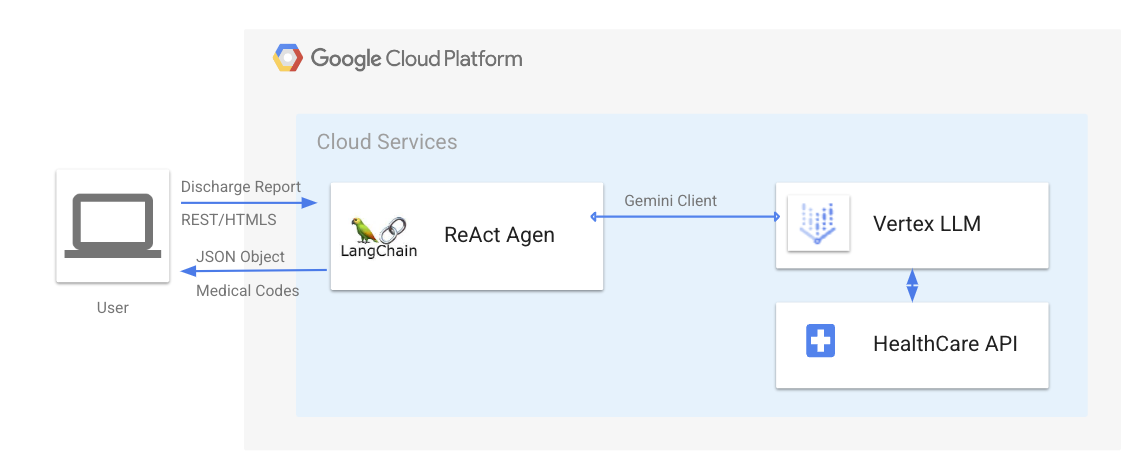

# Authenticate and Setup!

In [2]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:

    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

In [3]:
# Tested with these package versions.
!pip install --upgrade google-cloud-aiplatform
!pip install langchain==0.0.354

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.3/803.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.6/218.6 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.3 MB/s eta 0:00:00


In [4]:
# restart the colab runtime

import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
PROJECT_ID = "elhadik-sandbox-2"  # @param{type:"string"}
LOCATION = "us-central1"  # @param{type:"string"}

In [2]:
import google.auth
import google.auth.transport.requests

creds, project = google.auth.default()

# get access token

auth_req = google.auth.transport.requests.Request()
creds.refresh(auth_req)
creds.token

'ya29.a0AfB_byC-WOsUO-FO1nolSELAFwZ_ecG91isDTNvaqapTin_WHVa-FqOnejjuYuWI18eUvI4KP6GHDkyRKWjf_96g1tClAKSmR3TI174mOQ7MXagu7pxErgC1hAzxi7sv5s2DOIvr92qGgDGBrizhcDjot8SRUAznVAaCgYKARQSARMSFQHGX2MiOjCwgc-pg918W_gqxVn0bw0169'

In [3]:
import json
import requests

# Call healthcare API and set it up as a custom tool

### Example of Discharge Summary:
---

>"Most Responsible Diagnosis: COPD Exacerbation Active Issues Managed in Hospital: Pulmonary edema Microcytic anemia Gout Purpuric rash NYD  Course in Hospital:  Mr. Johnson arrived in the ER from nursing home with a three-day history of worsening shortness of breath, yellow-green sputum, and increased sputum production. He was subsequently diagnosed with a COPD exacerbation and was satting at 84% on 4L O2 by nasal prongs. He was stepped up to BiPAP for 24 hours and prednisone, ciprofloxacin, and around the clock puffers were initiated. By day 2 of admission he was stepped down to oxygen by nasal prongs and QID puffers.  In terms of respiratory complications, Mr. Johnson had a sudden hypoxic resp failure on day 3 of admission. CCOT was involved, but ICU was avoided. He was found to be in pulmonary edema that responded to diuresis. Last documented echo was completed 15 years ago and a repeat echo was ordered to be completed as an outpatient.    Unfortunately on day 4 of admission Mr. Johnson also developed gout in the left MTP. This limited his mobility and contributed to deconditioning for which PT was involved. Also, by day 6 of admission a purpuric rash was noted on the upper and lower extremities, cause was unknown and punch biopsy was performed. The results are still pending. Lastly, upon admission Mr. Johnson was found to have a microcytic anemia. On history Mr. Johnson states he no longer eats much red meat or leafy greens, preferring tea and toast for most of his meals. There was no history of bleeding and previous FOBT testing was normal. Further testing revealed iron deficiency anemia and therapy with ferrous fumarate was initiated.   On day of discharge, Ms. Johnson was on room air but continued to be on Lasix.  Continued Home Medications: Albuterol 2 puffs q 4-6 hours daily Atrovent 2 puffs q 6h ASA 325 mg daily Metoprolol 25 mg BID Atorvastatin 40 mg daily Ramipril 10 mg daily Amlodipine 5 mg daily Metformin 1000 mg BID Terazosin 5 mg qhs Tylenol 325 mg qhs Lactulose 15cc qhs prn Citalopram 20 mg daily Multivitamin  Medications Changes: Ramipril was STOPPED Lasix was STARTED at 20mg PO BID Amlodipine was INCREASED to 10mg daily Ferrous fumarate 325 mg QHS was STARTED  Important Test Results:  CXR completed April 20th 2019 revealed pulmonary edema and enlarged cardiac silhouette Sputum culture collected April 18th 2019 was positive for pseudomonas aeruginosa  Pending Tests or Results: Echo ordered as outpatient Skin biopsy results pending  Follow-up Plans:  We asked the patient to make an appointment with their family MD next week. The patient will follow up in urgent resp clinic in 2-4 weeks time. Since moving to London the patient is not currently followed by a respirologist and since this is the third exacerbation this year a goals of care discussion may be warranted. The patient was also seen by our COPD Navigator Team and arrangements have been made to be seen as an outpatient."

In [5]:
# @title Enter the Discharge Report Summary
TEXT = "Most Responsible Diagnosis: COPD Exacerbation  Active Issues Managed in Hospital: Pulmonary edema Microcytic anemia Gout Purpuric rash NYD  Course in Hospital:  Mr. Johnson arrived in the ER from nursing home with a three-day history of worsening shortness of breath, yellow-green sputum, and increased sputum production. He was subsequently diagnosed with a COPD exacerbation and was satting at 84% on 4L O2 by nasal prongs. He was stepped up to BiPAP for 24 hours and prednisone, ciprofloxacin, and around the clock puffers were initiated. By day 2 of admission he was stepped down to oxygen by nasal prongs and QID puffers.  In terms of respiratory complications, Mr. Johnson had a sudden hypoxic resp failure on day 3 of admission. CCOT was involved, but ICU was avoided. He was found to be in pulmonary edema that responded to diuresis. Last documented echo was completed 15 years ago and a repeat echo was ordered to be completed as an outpatient.    Unfortunately on day 4 of admission Mr. Johnson also developed gout in the left MTP. This limited his mobility and contributed to deconditioning for which PT was involved. Also, by day 6 of admission a purpuric rash was noted on the upper and lower extremities, cause was unknown and punch biopsy was performed. The results are still pending. Lastly, upon admission Mr. Johnson was found to have a microcytic anemia. On history Mr. Johnson states he no longer eats much red meat or leafy greens, preferring tea and toast for most of his meals. There was no history of bleeding and previous FOBT testing was normal. Further testing revealed iron deficiency anemia and therapy with ferrous fumarate was initiated.   On day of discharge, Ms. Johnson was on room air but continued to be on Lasix.  Continued Home Medications: Albuterol 2 puffs q 4-6 hours daily Atrovent 2 puffs q 6h ASA 325 mg daily Metoprolol 25 mg BID Atorvastatin 40 mg daily Ramipril 10 mg daily Amlodipine 5 mg daily Metformin 1000 mg BID Terazosin 5 mg qhs Tylenol 325 mg qhs Lactulose 15cc qhs prn Citalopram 20 mg daily Multivitamin  Medications Changes: Ramipril was STOPPED Lasix was STARTED at 20mg PO BID Amlodipine was INCREASED to 10mg daily Ferrous fumarate 325 mg QHS was STARTED  Important Test Results:  CXR completed April 20th 2019 revealed pulmonary edema and enlarged cardiac silhouette Sputum culture collected April 18th 2019 was positive for pseudomonas aeruginosa  Pending Tests or Results: Echo ordered as outpatient Skin biopsy results pending  Follow-up Plans:  We asked the patient to make an appointment with their family MD next week. The patient will follow up in urgent resp clinic in 2-4 weeks time. Since moving to London the patient is not currently followed by a respirologist and since this is the third exacerbation this year a goals of care discussion may be warranted. The patient was also seen by our COPD Navigator Team and arrangements have been made to be seen as an outpatient."  # @param{type:"string"}

*   The Cloud Healthcare API provides industry-standard protocols and formats for ingesting, storing, analyzing, and integrating healthcare data with cloud-based applications. In the section below, we call the Google Healthcare API to preprocess medical records, in this case, a discharge report. Medical records can be unstructured text and are usually hard to read. The Healthcare API can help with this problem by extracting all medical terms from the unstructured text, identifying patterns, and establishing medical relationships.

*   You can learn more about Google Healthcare API [here](https://cloud.google.com/healthcare-api?hl=en)


---








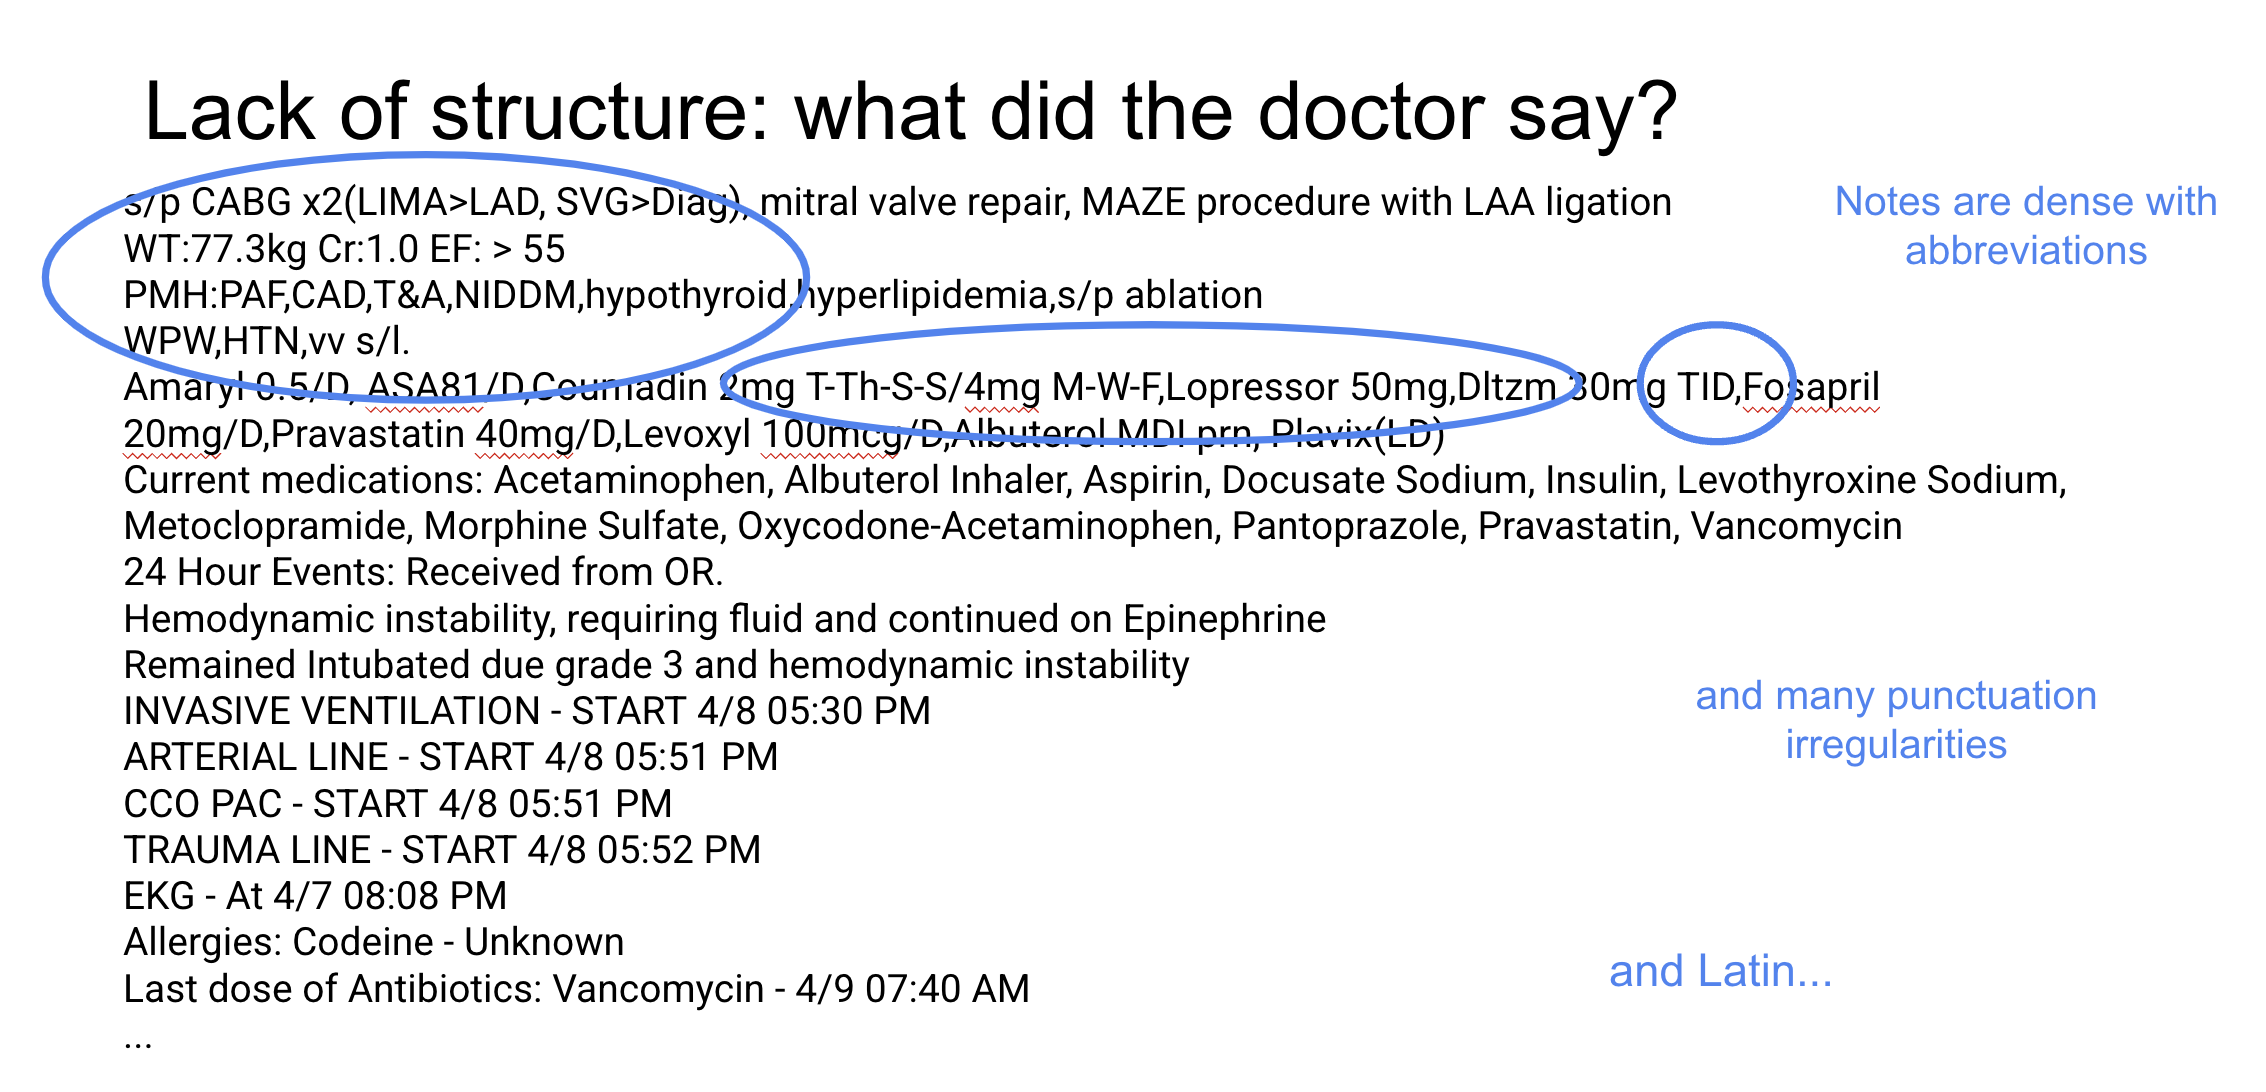


In [6]:
# @title Define the healthcare_nl method


def list_of_medical_terms(text: str) -> str:
    """Sends a REST request to the given healthcare API to retrieve medical terms for diagnosis, procedures, medicines, and lab data"""
    # Set the API endpoint
    url = f"https://healthcare.googleapis.com/v1/projects/{PROJECT_ID}/locations/{LOCATION}/services/nlp:analyzeEntities"

    # Set the request headers
    headers = {
        "Authorization": f"Bearer  {creds.token}",
        "X-Goog-User-Project": PROJECT_ID,
        "Content-Type": "application/json",
        "Accept": "application/json",
    }

    # Set the request data
    data = {"documentContent": text, "licensedVocabularies": ["SNOMEDCT_US", "ICD10CM"]}

    # Make the API request
    response = requests.post(url, headers=headers, data=json.dumps(data))

    entity_list = []
    type_categories = [
        "PROBLEM",
        "MEDICINE",
        "MEDICAL_DEVICE",
        "PROCEDURE",
        "LABORATORY_DATA",
    ]

    # Extract the entities from the response
    for entity in response.json()["entityMentions"]:
        if entity["type"] in type_categories:
            entity_list.append(entity["text"]["content"])

    # remove duplicates
    entity_list = list(set(entity_list))

    return entity_list


list_of_medical_terms(TEXT)

['ciprofloxacin',
 'COPD',
 'punch biopsy',
 'Amlodipine',
 'Microcytic anemia',
 'deconditioning',
 'pulmonary edema',
 'yellow-green sputum',
 'CCOT',
 'bleeding',
 'biopsy',
 'iron deficiency anemia',
 'Atorvastatin',
 'Tylenol',
 'Gout Purpuric rash',
 'PT',
 'oxygen',
 'purpuric rash',
 'Pulmonary edema',
 'Echo',
 'Lasix',
 'shortness of breath',
 'microcytic anemia',
 'Terazosin',
 'diuresis',
 'Multivitamin',
 'BiPAP',
 'ferrous fumarate',
 'gout',
 'therapy',
 'FOBT testing',
 'ASA',
 'Atrovent',
 'Lactulose',
 'enlarged',
 'pseudomonas aeruginosa',
 'nasal prongs',
 'prednisone',
 'Issues',
 'Metformin',
 'O2',
 'Metoprolol',
 'Ferrous fumarate',
 'CXR',
 'echo',
 'Ramipril',
 'Citalopram',
 'Sputum culture',
 'sudden hypoxic resp failure',
 'sputum production',
 'Albuterol',
 'respiratory complications']

*   In the below section we use python Knowldge Graph libary, networkx, to visualize the relationships among medical terms that were captured by the healthcare API. This is to illustrate the relationships that Healthcare API draws among the different medical terms, such as the relation between a medication and the recommend dose frequency, or the relation between a diagnosis and its severity


---


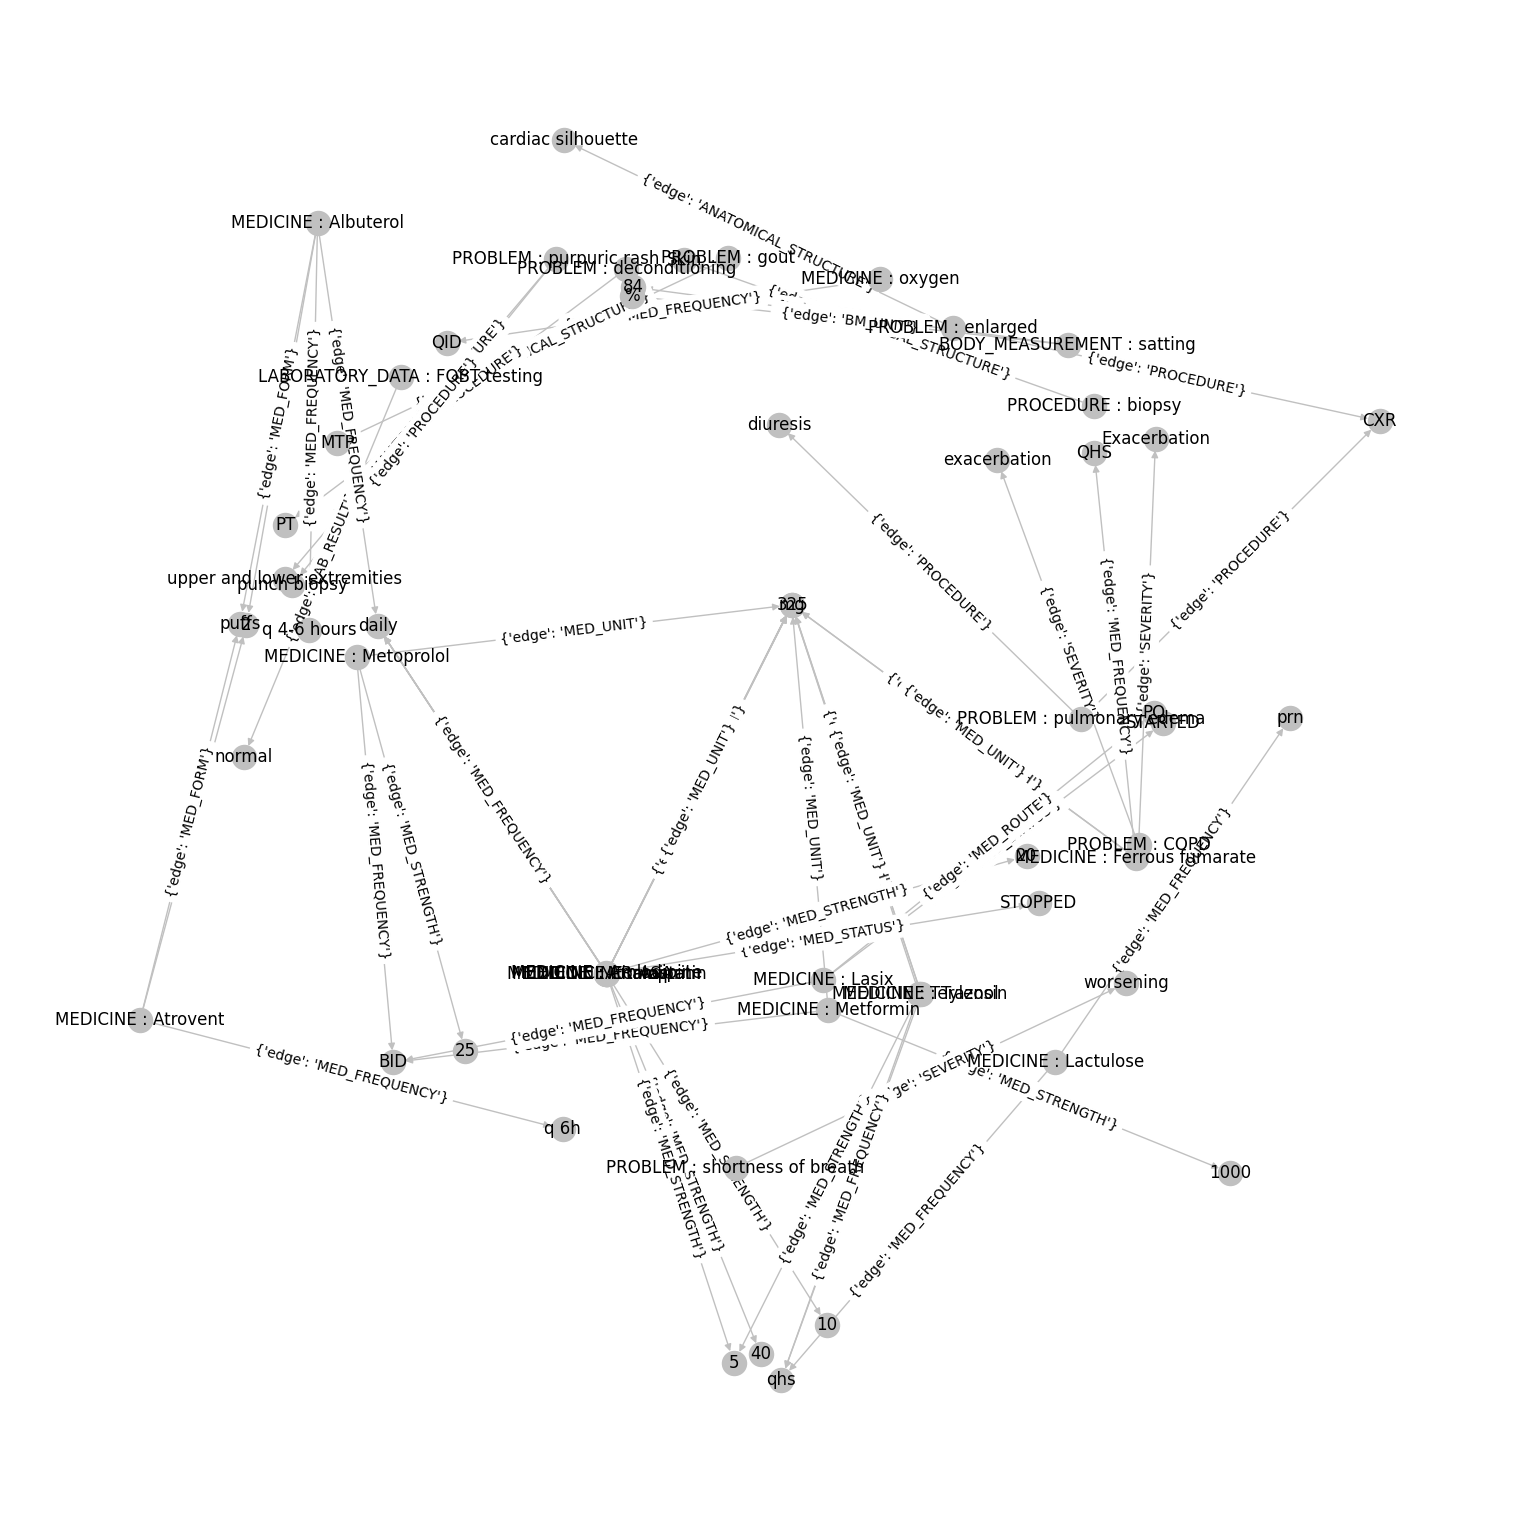

In [7]:
# @title Visualize Healthcare NLP

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd


def healthcare_nl(text: str):
    # Set the API endpoint
    url = f"https://healthcare.googleapis.com/v1/projects/{PROJECT_ID}/locations/{LOCATION}/services/nlp:analyzeEntities"

    # Set the request headers
    headers = {
        "Authorization": f"Bearer {creds.token}",
        "X-Goog-User-Project": PROJECT_ID,
        "Content-Type": "application/json",
        "Accept": "application/json",
    }

    # Set the request data
    data = {"documentContent": text, "licensedVocabularies": ["SNOMEDCT_US", "ICD10CM"]}

    # Make the API request
    response = requests.post(url, headers=headers, data=json.dumps(data))

    # return
    return response


# Extract the entities from the response
response = healthcare_nl(TEXT)
len(response.json()["entityMentions"])
response.json()
entity_list = []

# get the entities
for entity in response.json()["entityMentions"]:
    desc = entity["type"] + " : " + entity["text"]["content"]
    type = entity["type"]
    content = entity["text"]["content"]
    entity_list.append([entity["mentionId"], desc, type, content])

df = pd.DataFrame(entity_list, columns=["ID", "Desc", "Type", "Content"])

# delcar sources, targets, and edges for the knowledge graph
relation_list = []
Source = []
Target = []
Edge = []

# get the relations
for relation in response.json()["relationships"]:
    source_id = relation["subjectId"]
    desc = df.loc[df["ID"] == source_id]["Desc"].values[0]
    target_id = relation["objectId"]
    content = df.loc[df["ID"] == target_id]["Content"].values[0]
    edge = (df.loc[df["ID"] == target_id])["Type"].values[0]

    Source.append(desc)
    Target.append(content)
    Edge.append(edge)

kg_df = pd.DataFrame({"source": Source, "target": Target, "edge": Edge})

# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(
    kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph()
)

plt.figure(figsize=(15, 15))


# draw the graph
nx.draw(
    G,
    with_labels=True,
    pos=nx.kamada_kawai_layout(G),
    edge_color="silver",
    node_color="silver",
)
nx.draw_networkx_edge_labels(G, pos=nx.kamada_kawai_layout(G))

plt.show()

In [8]:
# @title Define the prompt

prompt = """

pretend that you are a professional medical coder
First:  Pass on the entire text to the list_of_medical_terms tool to find the correct medical terms in the discharge report
Second: Find the associated medical codes and their short explanation, for these medical terms that you just retrived,  and use only the below codes:
  1- ICD-10 : International Classification of Diseases, 10th Revision,
  2- CPT Codes:  Current Procedural Terminology,
  3- DRG Codes: Diagnosis Related Groups.
  4- HCPCS Codes: Healthcare Common Procedure Coding System.
Third:  Format the output as a JSON object with the following keys:
        Code_Type
        Code_Value
        Code_Explanation




   {discharge_report}


"""
prompt = prompt.format(discharge_report=TEXT)

The section below we use langchain ReAct agent (reasoning + actions), which combines chain of thought and tool usage together to reason through comlex tasks by interacting with external systems, in this case external system is the healthcare API.

ReAct-style prompting is currently (Fall 2023) the state-of-the-art for most prompt-driven LLM tasks. When you use plugins or extensions, where an LLM or LLM-based chatbot or system interacts with an external system, you are using a ReAct-style system. In general, any LLM system that reflects up-to-date knowledge is invisibly using ReAct-style functionality under-the-hood.



ReAct chains typically have three interleaved parts:
- **Thoughts**: Like in chain of thought, these are waypoints, plans, reasoning, etc. generated by the LLM as it makes progress towards the final output.
- **Actions**: LLM-generated commands, calls, or instructions to access an external system. The external system may be a tool that provides information, but can also be more general (i.e., the action observes or changes the state of an external system).
- **Observations**: A response, feedback, result, etc. from the external system, inserted into an LLM call to generate the next thought.

These three steps are repeated until the LLM completes its task.



**We are using LangChain ReAct as a quick means for prototyping, but you may also consider other prompting techniques like chain of thought or calling the LLM directly****


---


In [9]:
# @title Call the LLM and pass on the healthcare API as a custom tool and show reasoning steps

import vertexai
from langchain.agents import AgentType, initialize_agent
from langchain.llms import VertexAI
from langchain.tools import StructuredTool

# Initialize the Vertex AI client
vertexai.init(project=PROJECT_ID, location=LOCATION)

# Create the custom tool that will call the external system to extract the medical terms from the patient records
tool = StructuredTool.from_function(list_of_medical_terms)
tools = [tool]

# Create the LLM.
# This is the langchain connection to Vertex AI.
# Note this depends on vertexai.init
llm = VertexAI(model_name="gemini-pro", max_output_tokens=8042, temperature=0)


# Create the ReAct agent.
agent = initialize_agent(
    tools,
    llm,
    verbose=True,
    max_execution_time=1000,
    max_iterations=3,
    handle_parsing_errors=True,
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
)

# call the LLM
agent.run(prompt)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.vertexai.VertexAI` was deprecated in langchain-community 0.0.12 and will be removed in 0.2.0. An updated version of the class exists in the langchain-google-vertexai package and should be used instead. To use it run `pip install -U langchain-google-vertexai` and import as `from langchain_google_vertexai import VertexAI`.
  warn_deprecated(




> Entering new AgentExecutor chain...
Action:
```
{
  "action": "list_of_medical_terms",
  "action_input": {
    "text": "COPD Exacerbation Pulmonary edema Microcytic anemia Gout Purpuric rash NYD COPD exacerbation BiPAP prednisone ciprofloxacin puffers hypoxic resp failure CCOT ICU diuresis echo gout MTP PT purpuric rash punch biopsy microcytic anemia iron deficiency anemia ferrous fumarate Lasix Albuterol Atrovent ASA Metoprolol Atorvastatin Ramipril Amlodipine Metformin Terazosin Tylenol Lactulose Citalopram Multivitamin CXR pulmonary edema enlarged cardiac silhouette Sputum culture pseudomonas aeruginosa Echo ordered as outpatient Skin biopsy results pending"
  }
}
```
Observation: ['ciprofloxacin', 'COPD', 'punch biopsy', 'Amlodipine', 'NYD', 'Microcytic anemia', 'pulmonary edema', 'biopsy', 'iron deficiency anemia', 'hypoxic resp failure', 'Atorvastatin', 'Tylenol', 'MTP', 'Albuterol Atrovent', 'purpuric rash', 'Pulmonary edema', 'Echo', 'Lasix', 'microcytic anemia', 'Terazosin

'{\n "Code_Type": "ICD-10",\n "Code_Value": "J44.1",\n "Code_Explanation": "COPD exacerbation"\n},\n{\n "Code_Type": "ICD-10",\n "Code_Value": "J81",\n "Code_Explanation": "Pulmonary edema"\n},\n{\n "Code_Type": "ICD-10",\n "Code_Value": "D63.81",\n "Code_Explanation": "Microcytic anemia"\n},\n{\n "Code_Type": "ICD-10",\n "Code_Value": "M10.0",\n "Code_Explanation": "Gout"\n},\n{\n "Code_Type": "ICD-10",\n "Code_Value": "L98.9",\n "Code_Explanation": "Purpuric rash"\n},\n{\n "Code_Type": "CPT Codes",\n "Code_Value": "95825",\n "Code_Explanation": "BiPAP"\n},\n{\n "Code_Type": "CPT Codes",\n "Code_Value": "94660",\n "Code_Explanation": "Punch biopsy"\n},\n{\n "Code_Type": "CPT Codes",\n "Code_Value": "93015",\n "Code_Explanation": "Sputum culture"\n},\n{\n "Code_Type": "CPT Codes",\n "Code_Value": "78653",\n "Code_Explanation": "Echo"\n},\n{\n "Code_Type": "DRG Codes",\n "Code_Value": "895",\n "Code_Explanation": "COPD with exacerbation"\n},\n{\n "Code_Type": "DRG Codes",\n "Code_Value"

In [13]:
# @title Call the LLM and pass on the healthcare API as a custom tool and do not show reasoning steps

agent = initialize_agent(
    tools,
    llm,
    verbose=False,
    max_execution_time=1000,
    max_iterations=3,
    handle_parsing_errors=True,
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
)

agent.run(prompt)

'{\n "Code_Type": "ICD-10",\n "Code_Value": "J44.1",\n "Code_Explanation": "COPD exacerbation"\n},\n{\n "Code_Type": "ICD-10",\n "Code_Value": "J81",\n "Code_Explanation": "Pulmonary edema"\n},\n{\n "Code_Type": "ICD-10",\n "Code_Value": "D63.81",\n "Code_Explanation": "Microcytic anemia"\n},\n{\n "Code_Type": "ICD-10",\n "Code_Value": "M10.0",\n "Code_Explanation": "Gout"\n},\n{\n "Code_Type": "ICD-10",\n "Code_Value": "L98.9",\n "Code_Explanation": "Purpuric rash"\n},\n{\n "Code_Type": "CPT Codes",\n "Code_Value": "95825",\n "Code_Explanation": "BiPAP"\n},\n{\n "Code_Type": "CPT Codes",\n "Code_Value": "94660",\n "Code_Explanation": "Punch biopsy"\n},\n{\n "Code_Type": "CPT Codes",\n "Code_Value": "93015",\n "Code_Explanation": "Sputum culture"\n},\n{\n "Code_Type": "CPT Codes",\n "Code_Value": "78653",\n "Code_Explanation": "Echo"\n},\n{\n "Code_Type": "DRG Codes",\n "Code_Value": "895",\n "Code_Explanation": "COPD with exacerbation"\n},\n{\n "Code_Type": "DRG Codes",\n "Code_Value"

*   Repeatedly querying a model with the same prompt and selecting the majority response as the final answer, a technique known as ***self-consistency***, demonstrably improves performance on arithmetic, commonsense reasoning, and symbolic tasks.


---


In [11]:
count = 0
outputs = []
vote = 0
final_output = ""
num_of_attempts = 10

# call the LLM
for count in range(num_of_attempts):
    tmp = agent.run(prompt)
    outputs.append(tmp)
    temp_vote = outputs.count(tmp)
    if temp_vote > vote:
        vote = temp_vote
        final_output = tmp

print(f"vote count: {vote}")
print(f"final_output: {final_output}")

vote count: 4
final_output: {
 "Code_Type": "ICD-10",
 "Code_Value": "J44.1",
 "Code_Explanation": "COPD exacerbation"
},
{
 "Code_Type": "ICD-10",
 "Code_Value": "J81",
 "Code_Explanation": "Pulmonary edema"
},
{
 "Code_Type": "ICD-10",
 "Code_Value": "D63.81",
 "Code_Explanation": "Microcytic anemia"
},
{
 "Code_Type": "ICD-10",
 "Code_Value": "M10.0",
 "Code_Explanation": "Gout"
},
{
 "Code_Type": "ICD-10",
 "Code_Value": "L98.9",
 "Code_Explanation": "Purpuric rash"
},
{
 "Code_Type": "CPT Codes",
 "Code_Value": "95825",
 "Code_Explanation": "BiPAP"
},
{
 "Code_Type": "CPT Codes",
 "Code_Value": "94660",
 "Code_Explanation": "Punch biopsy"
},
{
 "Code_Type": "CPT Codes",
 "Code_Value": "93015",
 "Code_Explanation": "Sputum culture"
},
{
 "Code_Type": "CPT Codes",
 "Code_Value": "78653",
 "Code_Explanation": "Echo"
},
{
 "Code_Type": "DRG Codes",
 "Code_Value": "895",
 "Code_Explanation": "COPD with exacerbation"
},
{
 "Code_Type": "DRG Codes",
 "Code_Value": "896",
 "Code_Explanati